<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [2]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c dog-breed-identification

100% 691M/691M [00:30<00:00, 25.7MB/s]
100% 691M/691M [00:30<00:00, 23.6MB/s]


In [6]:
!unzip dog-breed-identification.zip -d data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488

Let's use 64 most frequent breeds to simplify the task.

In [7]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [8]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


<ipython-input-8-0037ea12ab23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-8-0037ea12ab23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = labels.groupby('breed').rank()['id']


Custom dataset is going to be useful for our needs.

In [9]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [10]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


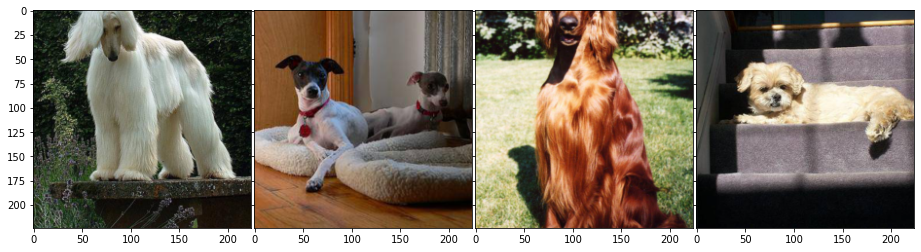

In [12]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([4, 1000])

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [14]:

def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    best_model = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(train_dl.dataset), 'valid': len(valid_dl.dataset)}

    for epoch in range(num_epochs): # here we have 1, adding this for general cases
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if str(device) == "cuda":
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model = model.state_dict()

        print("Train accuracy {:4f}".format(train_epoch_acc))
        print("Valid accuracy {:4f}".format(valid_epoch_acc))
    model.load_state_dict(best_model)
    return model

In [15]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features
num_fea = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_fea, 64)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [16]:
model = train_model(dloaders, resnet, criterion, optimizer, scheduler)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train accuracy 0.403472
Valid accuracy 0.784298


In [17]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

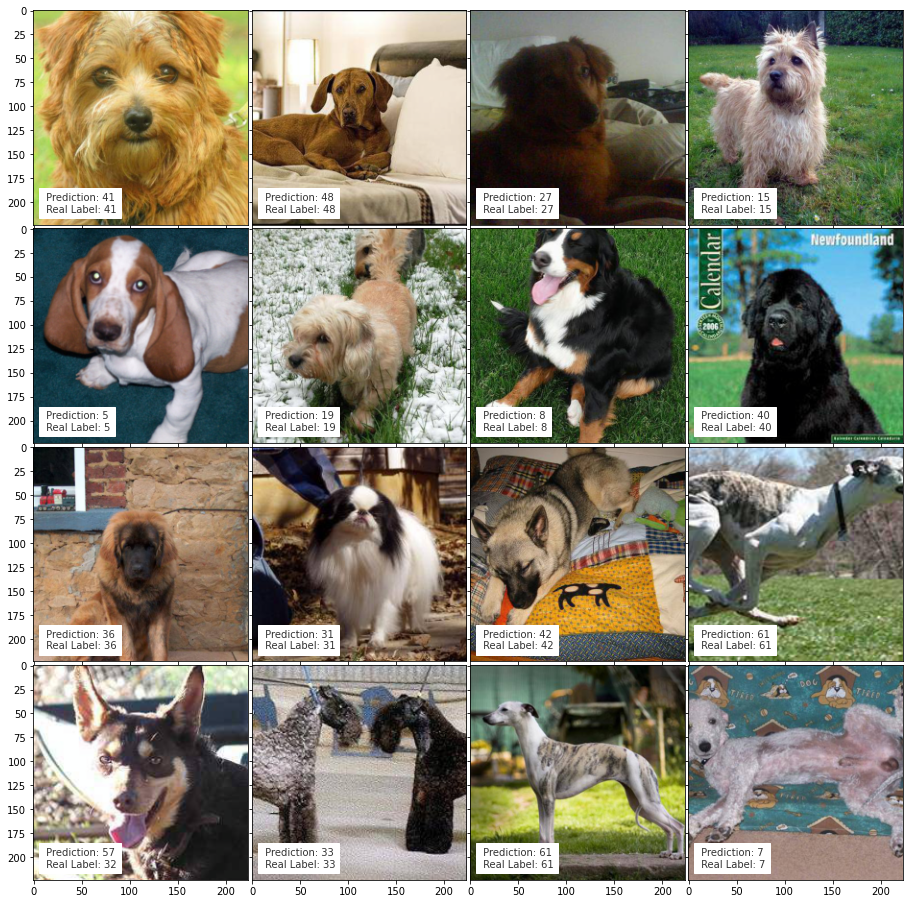

In [18]:
visualize_model(dloaders, model)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

In [19]:
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import AxesGrid
random.seed(2337)
torch.manual_seed(2337)

In [20]:
class AutoEncoder(nn.Module):
    
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=dim_input, out_channels=16, kernel_size=5),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.Conv2d(in_channels=32, out_channels=dim_hidden, kernel_size=5),
            nn.Sigmoid()
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_hidden, out_channels=32, kernel_size=5),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5),
            nn.ConvTranspose2d(in_channels=16, out_channels=dim_input, kernel_size=5),
            nn.Sigmoid()
            )
        self.classifier = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*106*106, 128)
        self.fc2 = nn.Linear(128, 64)


        
    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        out = self.classifier(h)
        #print(out.size())
        out = torch.flatten(out, 1)
        #print(out.size())
        out = F.relu(self.fc1(out))
        #print(out.size())
        out = self.fc2(out)
        #print(out.size())

        return x_, out

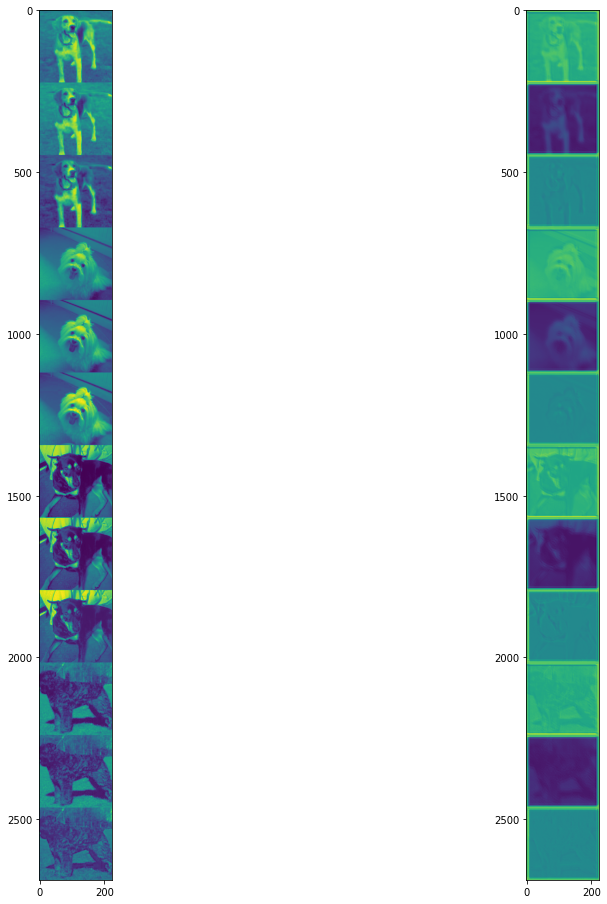

In [21]:
dim_hidden = 128
net_ae = AutoEncoder(3, dim_hidden).to(device)

# propagate a sample, before training
x = next(iter(train_dl))[0].to(device)
x_, out = net_ae(x)

# show the result
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*12, 224).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*12, 224).cpu().detach().numpy())
plt.show()

In [22]:
# get from autoencoder seminar
def train_epoch(net, loader, optimizer, criterion1, criterion2, device): 
    net.train()
    loss_avg = 0
    for x, labels in loader:
        # construct a batch
        x = x.to(device)
        labels = labels.to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward propagation
        x_, out = net(x)

        # compute the loss
        loss1 = criterion1(x_, x)
        loss2 = criterion2(out, labels)
        loss = loss1 + loss2

        # backward propagation
        loss.backward()

        # update the weights
        optimizer.step()

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [24]:
def test_epoch(net, loader, criterion1, criterion2, device): 
    net.eval()
    loss_avg = 0
    for x, labels in loader:
        # construct a batch
        x = x.to(device)
        labels = labels.to(device)

        # forward propagation
        x_, out = net(x)

        # compute the loss
        loss1 = criterion1(x_, x)
        loss2 = criterion2(out, labels)
        loss = loss1 + loss2

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [25]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion1, criterion2, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion1, criterion2, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion1, criterion2, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [26]:
lr = 1e-3
weight_decay = 1e-5
epochs = 3
net_ae = AutoEncoder(3, dim_hidden).to(device)
net_ae = net_ae.to(device)
# optimizer = torch.optim.SGD(net_ae.parameters(), lr=lr, momentum=0.9)
optimizer = optim.AdamW(net_ae.parameters(), lr=lr, weight_decay=weight_decay)
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
# criterion = torch.nn.CrossEntropyLoss()

In [27]:
train_loss, test_loss = train(net_ae, train_dl, valid_dl, 
                              optimizer, epochs, criterion1, criterion2, device) 

Epoch 1/3: Train loss = 13.6496 - Test loss = 4.9807
Epoch 2/3: Train loss = 4.9590 - Test loss = 4.9147
Epoch 3/3: Train loss = 4.9225 - Test loss = 4.8954


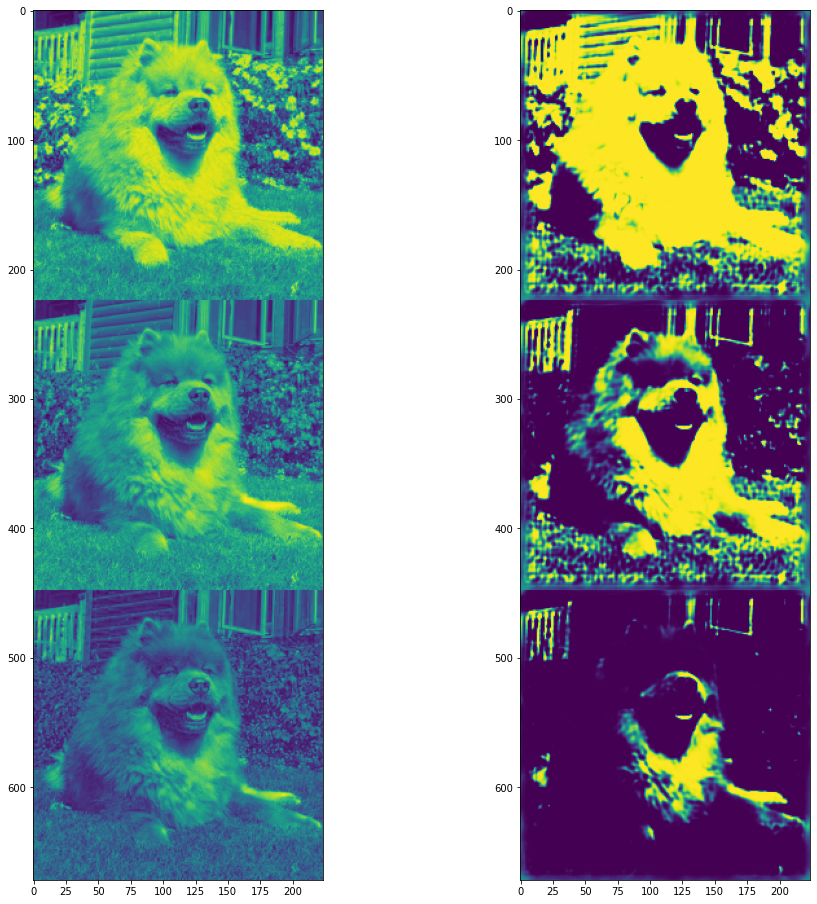

In [28]:

net_ae.eval()
x = train_dl.dataset[i][0].view(-1, 3, 224, 224).to(device)
x_, out = net_ae(x)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*3, 224).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*3, 224).cpu().detach().numpy())
plt.show()

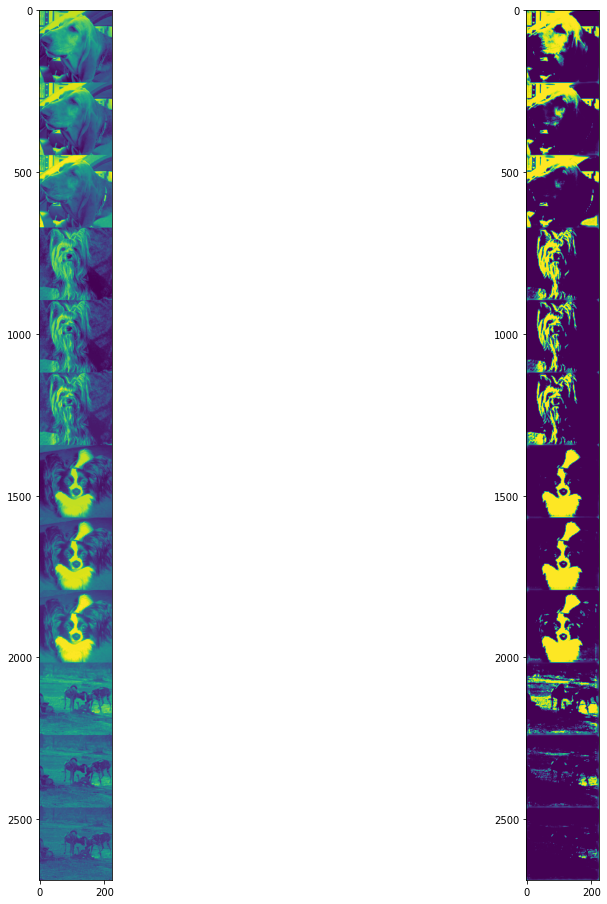

In [29]:
x = next(iter(train_dl))[0].to(device)
x_, out = net_ae(x)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*12, 224).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*12, 224).cpu().detach().numpy())
plt.show()

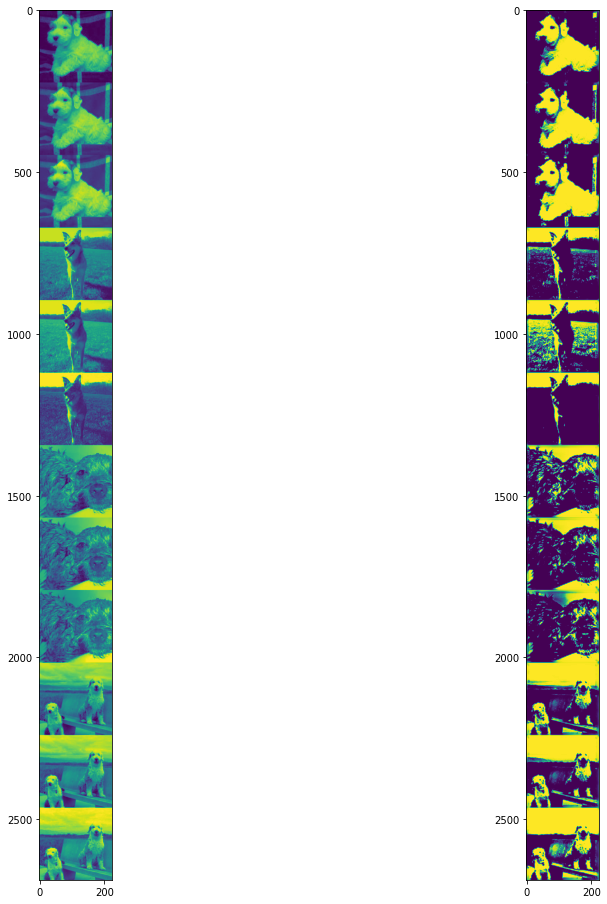

In [30]:
x = next(iter(valid_dl))[0].to(device)

x_, out = net_ae(x)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*12, 224).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*12, 224).cpu().detach().numpy())
plt.show()

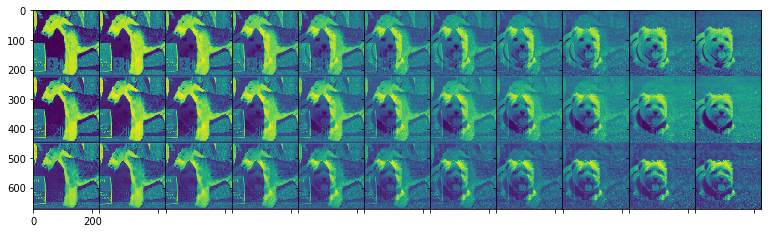

In [31]:
a = valid_dl.dataset[i][0].view(-1, 3, 224, 224)
b = valid_dl.dataset[i+1][0].view(-1, 3, 224, 224)

fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1")

for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    im = grid[k].imshow(z.view(224*3, 224).numpy(), interpolation="nearest")

<ipython-input-32-9cfdd0782ef9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(a.view(-1, 3, 224, 224)).to(device)
<ipython-input-32-9cfdd0782ef9>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(b.view(-1, 3, 224, 224)).to(device)


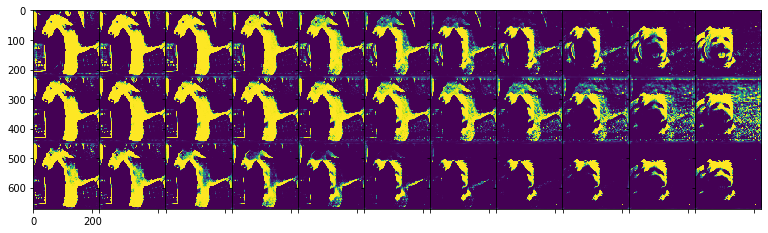

In [32]:
x = torch.tensor(a.view(-1, 3, 224, 224)).to(device)
a_emb = net_ae.encoder(x)   
x = torch.tensor(b.view(-1, 3, 224, 224)).to(device)
b_emb = net_ae.encoder(x) 

fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1",)

for k in range(11):
    # interpolate in latent space
    z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
    # use the latent code to decode the results
    z = net_ae.decoder(z_emb)
    im = grid[k].imshow(z.cpu().data.numpy().reshape(224*3, 224), interpolation="nearest")

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share. 

In [33]:
# select n samples for training and testing from dataset
def Subsamples(n):
    train_n = torch.utils.data.Subset(train_ds, range(n))
    valid_n = torch.utils.data.Subset(valid_ds, range(n))
    train_dl_n = DataLoader(train_n, batch_size=4, shuffle=True, num_workers=4)
    valid_dl_n = DataLoader(valid_n, batch_size=4, shuffle=True, num_workers=4)
    dloaders_n = {'train':train_dl_n, 'valid':valid_dl_n}
    return dloaders_n

In [34]:
def train_model_acc(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    best_model = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(train_dl.dataset), 'valid': len(valid_dl.dataset)}

    for epoch in range(num_epochs): # here we have 1, adding this for general cases
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if str(device) == "cuda":
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model = model.state_dict()

    model.load_state_dict(best_model)
    return train_epoch_acc, valid_epoch_acc

In [35]:
# functionalize the accounting, visualization precegure
def acc_plot(model):
  n_train_min = 10
  n_train_max = 200
  n_train_step = 10
  n_samples = np.arange(n_train_min, n_train_max, n_train_step)
  accuracies_br = np.zeros((len(n_samples)))
  accuracies_bl = np.zeros((len(n_samples)))
  for j in range(len(n_samples)):
    dloaders_n = Subsamples(n_samples[j])
    # boost trial
    accuracies_br[j] = train_model_acc(dloaders_n, model, criterion, optimizer, scheduler)[1].cpu().numpy()
    # baseline
    accuracies_bl[j] = train_model_acc(dloaders_n, resnet, criterion, optimizer, scheduler)[1].cpu().numpy()
  plt.plot(n_samples, accuracies_br)
  plt.plot(n_samples, accuracies_bl)
  plt.xlabel('Sample size training data')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend(('Task3', 'Baseline'))
  plt.show()
  return

In [36]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False
# add new layer
num_fea = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_fea, 64)
resnet = resnet.cuda()

In [37]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
outputs = resnet18(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([4, 1000])

In [38]:
for param in resnet18.parameters():
    param.requires_grad = False

# add new layer
num_fea = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_fea, 64)

resnet18 = resnet18.cuda()

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

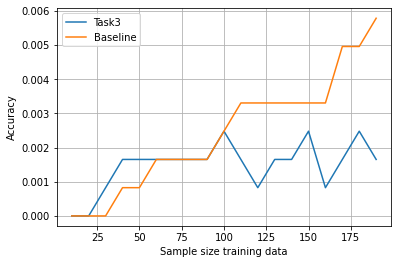

In [40]:
acc_plot(resnet18)

In [41]:
wide_resnet50 = models.wide_resnet50_2(pretrained=True)
wide_resnet50 = wide_resnet50.to(device)
outputs = wide_resnet50(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

torch.Size([4, 1000])

In [42]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x1):
        x2 = x1.detach().clone()
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = (x1 + x2) / 2  # 
        return x

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


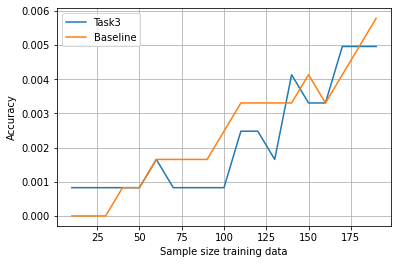

In [43]:
model_ensemble = MyEnsemble(resnet18, resnet)
acc_plot(model_ensemble)

In [44]:
densenet = models.densenet121(pretrained=True)
densenet = densenet.to(device)
outputs = densenet(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

torch.Size([4, 1000])

In [45]:
densenet = densenet.cuda()

In [46]:
class classifier(nn.Module):
  def __init__(self):
    super(classifier,self).__init__()
    self.encoder = nn.Sequential(nn.Linear(in_features=64, out_features=512), nn.Sigmoid())
    self.decoder = nn.Sequential(nn.Linear(in_features=512, out_features=64), nn.Sigmoid())
    self.dfc1=nn.Linear(1024,64)

  def forward(self,x):
    y = x.detach().clone()
    x = resnet(x)
    #x = self.encoder(x)
    #x = self.decoder(x)

    y = densenet.features(y)
    y = F.relu(y)
    y = F.adaptive_avg_pool2d(y, (1, 1))
    y = y.view(y.size(0), -1)
    y = self.dfc1(y)

    x = 0.8 * x + 0.2 * y

    return x

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


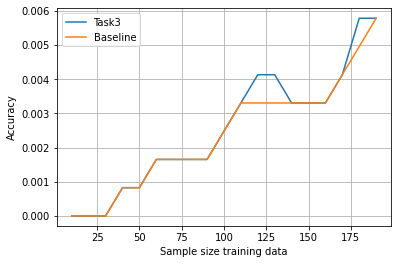

In [47]:
classi = classifier().to(device)
acc_plot(classi)